# KH-9 Panoramic Camera Collimation Rectification

The goal of this notebook is to illustrate and explain in detail the pipeline used for **collimation rectification** of KH-9 Panoramic Camera imagery.

This processing pipeline aims to extract the **Region of Interest (ROI)** from a joined KH-9 panoramic image by detecting and aligning the **collimation lines** — two bright horizontal lines located at the top and bottom of the ROI.  
These lines serve as geometric references to correct distortions and ensure that the image is properly rectified.

Please note that this pipeline is still **experimental** and may not be robust for all KH-9 images.  
It has been tested on a limited dataset (12 images from 2 sites), so results may vary depending on image quality and acquisition geometry.


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import hipp
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import AffineTransform, ThinPlateSplineTransform

In [5]:
raster_filepath = Path("/mnt/summer/USERS/DEHECQA/history/data_prep/iceland/kh9_pc_images/1980_08_22/joined_images/D3C1216-200533F022.tif")

## Step 1 : Detection of Collimation Lines

Detect the top and bottom collimation lines from a raster image using peak detection and RANSAC polynomial fitting.

This function extracts two horizontal bands (top and bottom) from a raster image,
detects prominent peaks corresponding to collimation features, and fits polynomial
models to them using a RANSAC regression approach. The resulting models represent
the collimation lines that can be used for geometric correction or alignment analysis.

`detect_peaks_in_collimation_line` :

Detect one peak per image column corresponding to the collimation line.

Two detection strategies are available:
    - **"distribution"**: selects the peak that maximizes the intensity difference
    between the left and right sides of the column around the candidate peak.
    This approach leverages the fact that the collimation line separates the
    Region of Interest (ROI) from the background. By maximizing the contrast
    between both sides, it avoids detecting bright lines located within the background.
    - **"prominence"**: selects the most prominent peak in each column based on
    local prominence criteria. This method is mainly used after rectification
    and cropping, where the distribution-based approach may fail.

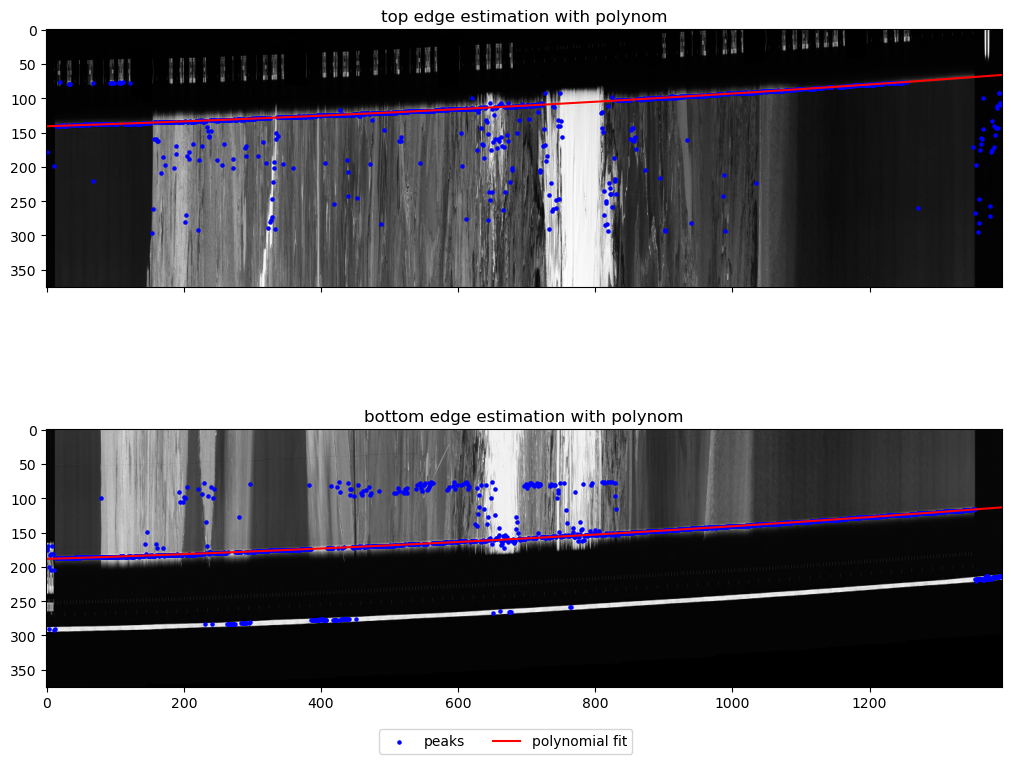

In [10]:

collimation_lines = hipp.kh9pc.collimation_lines.detect_collimation_lines(raster_filepath, peaks_strategy="distribution")


for exemple the prominence strategy works really well for the top cause we have only one line, but for the bottom line their is a parasite white line on the background which will maximize the prominence

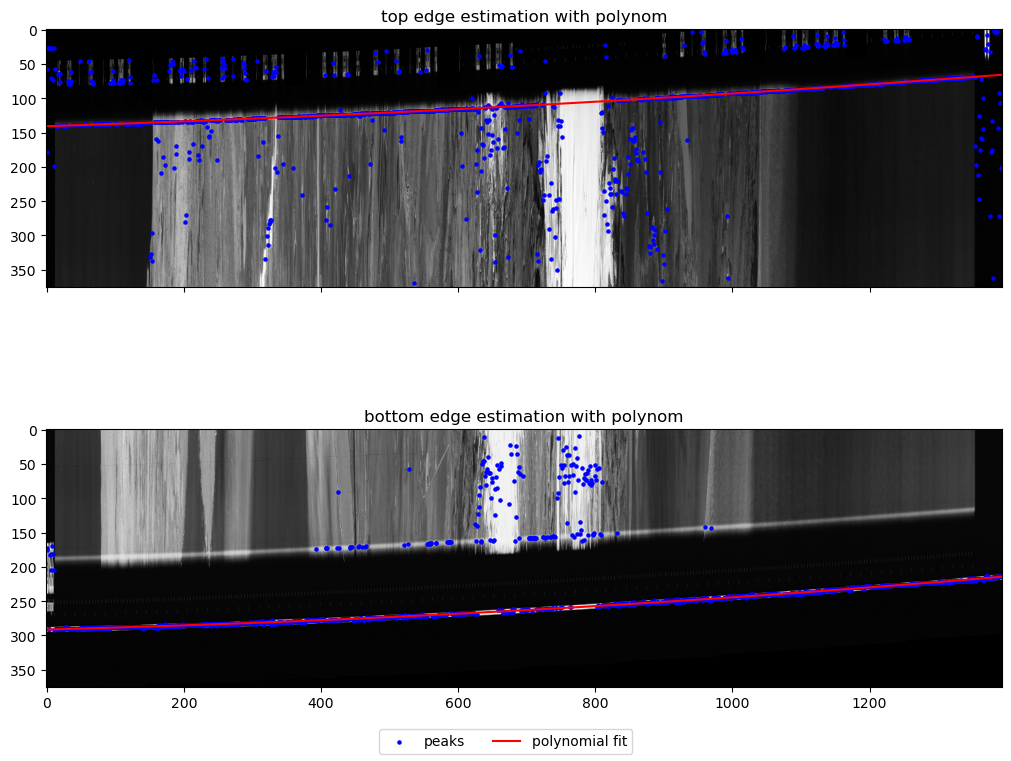

In [11]:
collimation_lines = hipp.kh9pc.collimation_lines.detect_collimation_lines(raster_filepath, peaks_strategy="prominence")


## Step 2 Detection of vertical edges

Detect the left and right vertical edges of a raster image using RANSAC regression.

This function extracts two vertical bands (left and right) from a raster image,
identifies strong vertical edge points based on pixel intensity changes, and fits
a robust RANSAC regression line to estimate the most probable edge position.
The detected vertical positions (in pixel coordinates) represent the image's
lateral boundaries, which can be used for geometric calibration or alignment tasks.

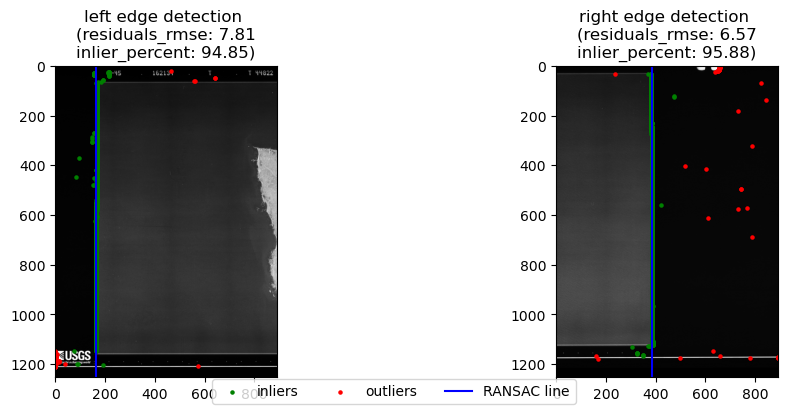

In [12]:
vertical_edges = hipp.kh9pc.collimation_lines.detect_vertical_edges(raster_filepath)

## Step 3 : Compute the source grid points, the target grid points and the output size

Generate source and destination control points for rectification
as structured 2D grids.

This function creates two corresponding 2D grids of control points:
- `src_points`: distorted coordinates from the detected vertical edges and horizontal
    RANSAC lines (top and bottom). Shape `(grid_shape[0], grid_shape[1], 2)`.
- `dst_points`: regular target coordinates forming a rectified rectangular grid.
    Shape `(grid_shape[0], grid_shape[1], 2)`.

The grids are generated column-wise: each column of points spans from top to bottom
between the detected/fitted top and bottom edges.

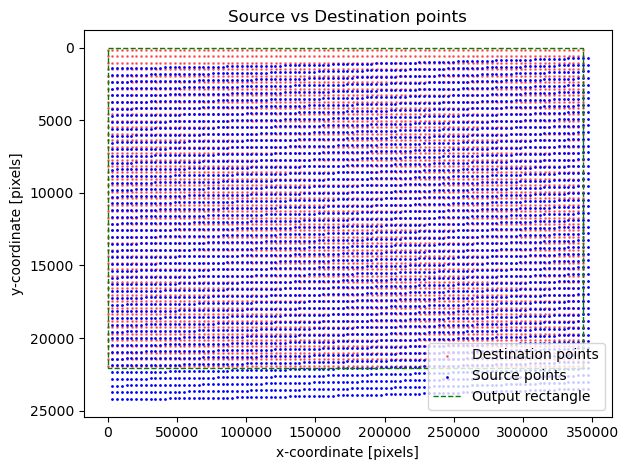

In [14]:
src_grid, dst_grid, output_size = hipp.kh9pc.collimation_lines.compute_source_and_target_grid(vertical_edges, collimation_lines)

src_points = src_grid.reshape(-1, 2)
dst_points = dst_grid.reshape(-1, 2)

hipp.kh9pc.qc.plot_src_and_dst_points(src_points, dst_points, output_size)

## Step 4 : Estimate the transformation between source and target points

We can apply various types of geometric transformations, but here we focus on comparing Affine and Thin Plate Spline (TPS) transformations.
Since some collimation lines are slightly curved, the Affine transformation — being limited to linear mappings — is not powerful enough to fully correct the distortion.
In contrast, the TPS transformation provides a flexible, non-linear warping that yields significantly better results.

In [16]:
tps_transform = ThinPlateSplineTransform()
affine_transform = AffineTransform()

tps_transform.estimate(src_points, dst_points)
affine_transform.estimate(src_points, dst_points)

tf_points_tps = tps_transform(src_points)
tf_points_affine = affine_transform(src_points)

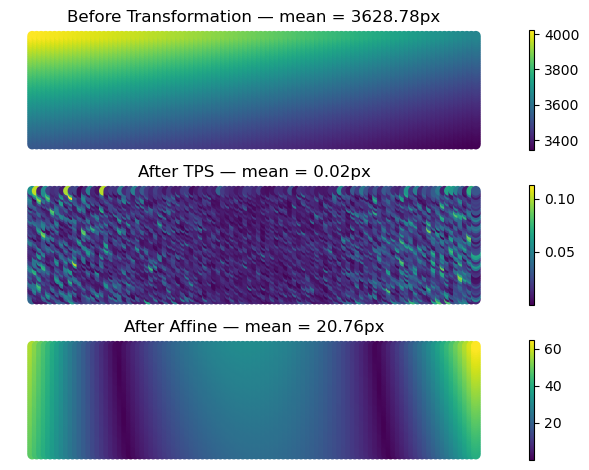

In [40]:
distances_before_tf = np.linalg.norm(dst_points - src_points, axis=1)
distances_tps = np.linalg.norm(dst_points - tf_points_tps, axis=1)
distances_affine = np.linalg.norm(dst_points - tf_points_affine, axis=1)

fig, axs = plt.subplots(3,1)
sc0 = axs[0].scatter(dst_points[:,0], dst_points[:,1], c=distances_before_tf)
axs[0].set_title(f"Before Transformation — mean = {distances_before_tf.mean():.2f}px")
plt.colorbar(sc0, ax=axs[0], orientation="vertical")

sc1 = axs[1].scatter(dst_points[:,0], dst_points[:,1], c=distances_tps)
axs[1].set_title(f"After TPS — mean = {distances_tps.mean():.2f}px")
plt.colorbar(sc1, ax=axs[1], orientation="vertical")

sc2 = axs[2].scatter(dst_points[:,0], dst_points[:,1], c=distances_affine)
axs[2].set_title(f"After Affine — mean = {distances_affine.mean():.2f}px")
plt.colorbar(sc2, ax=axs[2], orientation="vertical")
for ax in axs:
    ax.axis("off")
plt.tight_layout()

## Step 5 : Apply transformation to the image

Apply a geometric remapping on a GeoTIFF file in a memory-efficient, blockwise manner.

This function divides the output image into small blocks, computes a local inverse
remapping function for each block, reads only the required input data from the source
raster, applies a geometric transformation (via OpenCV `cv2.remap`), and writes the
result to the output GeoTIFF. This approach is optimized for large raster files that
cannot fit into memory entirely.

lowres_step : Optional subsampling factor for the coordinate grid used during remapping.
If greater than 1, the remapping grid is computed on a lower resolution
and interpolated back using `RectBivariateSpline`. This can significantly
speed up processing but slightly reduce geometric accuracy.

In [ ]:
inverse_tps = ThinPlateSplineTransform()
inverse_tps.estimate(dst_points, src_points)

output_path = "transformed_image.tif"

hipp.image.remap_tif_blockwise(
    raster_filepath,
    output_path,
    inverse_tps,
    output_size,
    block_size = 2*13,
    lowres_step = 100 # this parameters reduce the geometric accuracy but improve a lot the computing time
)

## Some usefull functions

all of this pipeline car be done with one function

In [ ]:
transformation = "tps" # or affine
hipp.kh9pc.core.collimation_rectification(raster_filepath, "transformed_image.tif","qc",  tranformation=transformation)

And for a batch of images 

In [ ]:
hipp.kh9pc.iter_collimation_rectification("input_dir", "output_dir", "qc", tranformation=transformation)